In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install -q kaggle

In [ ]:
!cp '/content/gdrive/MyDrive/kaggle Competition/kaggle.json' 'kaggle.json'

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d vkehfdl1/kidf-kpop-idol-dataset-female

 99% 1.02G/1.03G [00:36<00:00, 39.6MB/s]
100% 1.03G/1.03G [00:36<00:00, 30.1MB/s]


In [ ]:
!unzip /content/kidf-kpop-idol-dataset-female.zip

## Data Understanding

In [ ]:
import numpy as np
import pandas as pd
import urllib.request
import zipfile
import tensorflow as tf
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import os
import shutil
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

In [ ]:
data = pd.read_csv("kid_f_train.csv")
data.head(10)

,file_name,name
0,5.jpg,yujin
1,8.jpg,yujin
2,17.jpg,yujin
3,23.jpg,yujin
4,26.jpg,yujin
5,29.jpg,yujin
6,30.jpg,yujin
7,34.jpg,yujin
8,35.jpg,yujin
9,38.jpg,yujin


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5591 entries, 0 to 5590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  5591 non-null   object
 1   name       5591 non-null   object
dtypes: object(2)
memory usage: 87.5+ KB


## Data Wrangling

In [ ]:
members = ["jennie", "lisa", "jisoo", "rose"]

blackpink = data[data["name"].isin(members)]

Text(0.5, 1.0, "Total data of Blackpink's member")

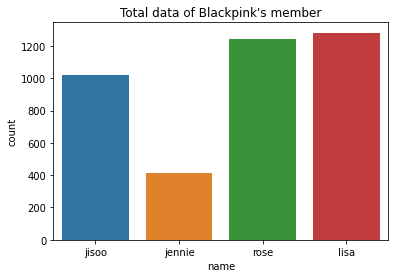

In [ ]:
ax = sns.countplot(data=blackpink, x='name')
ax.set_title("Total data of Blackpink's member")

In [ ]:
os.mkdir("data")
os.mkdir("data/train")
os.mkdir("data/test")

In [ ]:
members = ["jisoo", "lisa", "jennie", "rose"]
for i in members:
  os.mkdir(f"data/train/{i}")
  os.mkdir(f"data/test/{i}")

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(blackpink, test_size=0.2, random_state=0)
train.reset_index(inplace=True)
test.reset_index(inplace=True)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3171 entries, 0 to 3170
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      3171 non-null   int64 
 1   file_name  3171 non-null   object
 2   name       3171 non-null   object
dtypes: int64(1), object(2)
memory usage: 74.4+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 793 entries, 0 to 792
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      793 non-null    int64 
 1   file_name  793 non-null    object
 2   name       793 non-null    object
dtypes: int64(1), object(2)
memory usage: 18.7+ KB


In [ ]:
src_path = "/content/HQ_512x512/HQ_512x512"
dst_path_train = "/content/data/train"
dst_path_test = "/content/data/test"
files_image = os.listdir('/content/HQ_512x512/HQ_512x512')

In [ ]:
def move_files(df, files_image, src_path, dst_path):
  
  blackpink_member = ["jisoo", "lisa", "jennie", "rose"]

  for image in files_image:
    for _, gambar in df.iterrows():
      if image == gambar["file_name"]:
        if gambar["name"] in blackpink_member:
          src_file = os.path.join(src_path, image)
          dst_file = os.path.join(dst_path, gambar["name"], gambar["file_name"])
          shutil.move(src_file, dst_file)

In [ ]:
move_files(train, files_image, src_path, dst_path_train)
move_files(test, files_image, src_path, dst_path_test)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory(
        dst_path_train,
        target_size=(150, 150),
        batch_size=128,
        class_mode='categorical')

Found 3171 images belonging to 4 classes.


In [ ]:
val_datagen = ImageDataGenerator(rescale=1/255)
val_generator = train_datagen.flow_from_directory(
        dst_path_test,
        target_size=(150, 150),
        batch_size=128,
        class_mode='categorical')

Found 793 images belonging to 4 classes.


## Create Model

In [ ]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 17, 17, 128)     

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(
        train_generator,
        epochs=30,
        verbose=1,
        validation_data=val_generator)

Epoch 1/30
25/25 [==============================] - 25s 984ms/step - loss: 1.2815 - accuracy: 0.3942 - val_loss: 1.0233 - val_accuracy: 0.6166
Epoch 2/30
25/25 [==============================] - 23s 934ms/step - loss: 0.8783 - accuracy: 0.6619 - val_loss: 0.8163 - val_accuracy: 0.6683
Epoch 3/30
25/25 [==============================] - 25s 984ms/step - loss: 0.7440 - accuracy: 0.7301 - val_loss: 0.7413 - val_accuracy: 0.7100
Epoch 4/30
25/25 [==============================] - 23s 939ms/step - loss: 0.6442 - accuracy: 0.7553 - val_loss: 0.6943 - val_accuracy: 0.7137
Epoch 5/30
25/25 [==============================] - 23s 929ms/step - loss: 0.5758 - accuracy: 0.7789 - val_loss: 0.6554 - val_accuracy: 0.7276
Epoch 6/30
25/25 [==============================] - 23s 933ms/step - loss: 0.5256 - accuracy: 0.8004 - val_loss: 0.6620 - val_accuracy: 0.7453
Epoch 7/30
25/25 [==============================] - 25s 986ms/step - loss: 0.4537 - accuracy: 0.8281 - val_loss: 0.5804 - val_accuracy: 0.7755

## Evaluasi

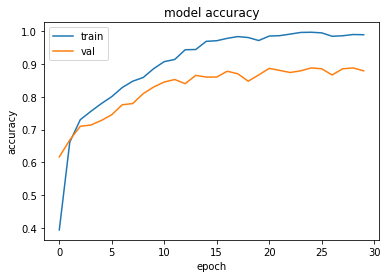

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()